In [26]:
import pandas as pd 
import numpy as np 
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
data_path = "data/train.csv"
data = pd.read_csv(data_path)
data

,text
0,valkyria chronicles iii
1,senjō no valkyria unk chronicles japanese 戦場のヴ...
2,the game began development in carrying over a ...
3,it met with positive sales in japan and was pr...
4,as with previous unk chronicles games valkyria...
...,...
23291,unk describes herself as optimistic cynical la...
23292,during a production of hamlet unk met her futu...
23293,unk has undertaken the following roles from he...
23294,film roles


In [3]:
def create_vocab(df: pd.DataFrame):
    vocab = set()
    for i, row in df.iterrows():
        vocab.update(row["text"].split())
    vocab = sorted(list(vocab))
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    idx_to_word = {idx: word for idx, word in enumerate(vocab)}
    
    return vocab, word_to_idx, idx_to_word

In [4]:
def create_data(data: pd.DataFrame, vocab: list, word_to_idx: dict, idx_to_word: dict):
    window = 2
    dataset = [] 
    for idx, row in data.iterrows():
        text = row["text"].split() 
        for target in range(window, len(text) - window):
            #create positive samples
            context = text[target-window:target] + text[target+1:target+window+1]
            target = text[target]
            data_pos = [[word_to_idx[target], word_to_idx[context_], 1] for context_ in context]
            
            #create negative samples
            random_idx = np.random.randint(0, len(vocab), size=window*2)
            data_neg = [[word_to_idx[target], idx, 0] for idx in random_idx]
            #append to data
            dataset.extend(data_pos)
            dataset.extend(data_neg)
    return torch.Tensor(dataset)


In [29]:
def train(w, c, dataset, lr, n_epochs=10, batch_size=64 , device= "cpu", lr_decay= (10,0.9)):
    lossf = nn.BCELoss(reduction= 'sum')
    # lossf = nn.BCEWithLogitsLoss(reduction='sum')

    losses = []

    w = w.to(device)
    c = c.to(device)

    for epoch in range(n_epochs):
        total_loss = 0
        current_loss = 0
        
        # for iter in tqdm(range(len(dataset) // batch_size), desc= f"Epoch {epoch}, loss = {current_loss:.2f}"):
        w_prev = w.clone().detach()
        
        pbar = tqdm(range(len(dataset) // batch_size))
        for iter in pbar:
            #create batch
            batch_start = iter * batch_size
            batch = dataset[batch_start:batch_start + batch_size]
            
            #create batch data tensor
            targets = torch.tensor(batch[:, 0], dtype=torch.long).clone().detach().to(device)
            contexts = torch.tensor(batch[:, 1], dtype=torch.long).clone().detach().to(device)
            labels = torch.tensor(batch[:, 2], dtype=torch.float32).clone().detach().to(device)

            # get part of w and c
            w_batch = w[targets, :].clone().detach()
            c_batch = c[contexts, :].clone().detach()
            w_batch = w_batch.requires_grad_().to(device)
            c_batch = c_batch.requires_grad_().to(device)

            pij = torch.sigmoid(torch.sum(w_batch * c_batch, dim=1, keepdim=True))  # Kích thước [batch_size, 1]
            
            # print(pij.shape)
            # print('prediction: ', pij[:2])
            # print(pij.shape)
            
            loss = lossf(pij.reshape(-1, 1), labels.reshape(-1, 1))
                        
            # print("loss: ", loss)
            # print("loss shape: ", loss.shape)

            # optimizer.zero_grad()
            loss.backward()
            # optimizer.step()

            with torch.no_grad():
                # print(type(w_batch))
                w[targets, :] -= lr * w_batch.grad
                c[contexts, :] -= lr * c_batch.grad
            
            del targets, contexts, labels, w_batch, c_batch, 

            total_loss += loss.item()
            
            if iter % 500 == 0 and iter > 0:
                current_loss = total_loss / (iter  * batch_size)
                pbar.set_description(f"Epoch {epoch}, loss = {current_loss:.4f}")
            
            if torch.sum(torch.abs(w - w_prev))< 1e-5:
                print("No update in w, break")
                print("w_batch_grad: ",w_batch.grad[0,:3])
                print("w_batch_grad max: " ,w_batch.grad.max())
                
                break
            w_prev = w.clone().detach()
            # exit()
        if lr_decay is not None:
            batch_step, decay_rate = lr_decay
            if (epoch + 1) % batch_step == 0:
                lr *= decay_rate
            
        losses.append(total_loss / len(dataset))  # Thêm loss trung bình cho mỗi epoch
    return w, c, losses

In [6]:
vocab, word_to_idx, idx_to_word = create_vocab(data)


In [7]:
print(vocab[:10])
print(word_to_idx["the"])
print(idx_to_word[0])
print(len(vocab))

['a', 'aa', 'aaa', 'aaat', 'aadt', 'aagadu', 'aak', 'aaknal', 'aalborg', 'aar']
24515
a
27326


In [8]:
dataset = create_data(data, vocab, word_to_idx, idx_to_word)

In [9]:
print(len(dataset))
dataset[:20]

14235776


tensor([[2.5912e+04, 2.1884e+04, 1.0000e+00],
        [2.5912e+04, 1.6655e+04, 1.0000e+00],
        [2.5912e+04, 2.5664e+04, 1.0000e+00],
        [2.5912e+04, 4.2620e+03, 1.0000e+00],
        [2.5912e+04, 4.6680e+03, 0.0000e+00],
        [2.5912e+04, 1.6035e+04, 0.0000e+00],
        [2.5912e+04, 1.3374e+04, 0.0000e+00],
        [2.5912e+04, 2.4839e+04, 0.0000e+00],
        [2.5664e+04, 1.6655e+04, 1.0000e+00],
        [2.5664e+04, 2.5912e+04, 1.0000e+00],
        [2.5664e+04, 4.2620e+03, 1.0000e+00],
        [2.5664e+04, 1.2842e+04, 1.0000e+00],
        [2.5664e+04, 1.3083e+04, 0.0000e+00],
        [2.5664e+04, 1.4790e+04, 0.0000e+00],
        [2.5664e+04, 1.3260e+03, 0.0000e+00],
        [2.5664e+04, 2.0944e+04, 0.0000e+00],
        [4.2620e+03, 2.5912e+04, 1.0000e+00],
        [4.2620e+03, 2.5664e+04, 1.0000e+00],
        [4.2620e+03, 1.2842e+04, 1.0000e+00],
        [4.2620e+03, 2.7323e+04, 1.0000e+00]])

In [10]:
for i in range(20):
    print(idx_to_word[int(dataset[i][0])], idx_to_word[int(dataset[i][1])], dataset[i][2])

valkyria senjō tensor(1.)
valkyria no tensor(1.)
valkyria unk tensor(1.)
valkyria chronicles tensor(1.)
valkyria colonialism tensor(0.)
valkyria mowgli tensor(0.)
valkyria kilmer tensor(0.)
valkyria tons tensor(0.)
unk no tensor(1.)
unk valkyria tensor(1.)
unk chronicles tensor(1.)
unk japanese tensor(1.)
unk junctions tensor(0.)
unk mandy tensor(0.)
unk argument tensor(0.)
unk robed tensor(0.)
chronicles valkyria tensor(1.)
chronicles unk tensor(1.)
chronicles japanese tensor(1.)
chronicles 戦場のヴァルキュリア tensor(1.)


In [31]:
d = 16
n_epochs = 10
lr = 0.1
batch_size = 4096
lr_decay = (10, 0.9)  #each 10 epochs, lr = lr * 0.9
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [30]:
w = torch.randn(len(vocab), d)
c = torch.randn(len(vocab), d)



In [13]:
w.is_leaf

True

In [14]:
w.shape

torch.Size([27326, 16])

In [15]:
#shuffle dataset
dataset = dataset[torch.randperm(len(dataset))]

In [33]:
w, c, loss_hisory = train(w=w, c=c, dataset=dataset, lr=lr, n_epochs=n_epochs, batch_size=batch_size, device=device, lr_decay=lr_decay)
# train(w=w, c=c, dataset=dataset, lr=lr, n_epochs=n_epochs, batch_size=batch_size, vocab=vocab, word_to_idx=word_to_idx, idx_to_word=idx_to_word, device=device)


  0%|          | 0/3475 [00:00<?, ?it/s]C:\Users\acer\AppData\Local\Temp\ipykernel_16264\2861586888.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(batch[:, 0], dtype=torch.long).clone().detach().to(device)
C:\Users\acer\AppData\Local\Temp\ipykernel_16264\2861586888.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  contexts = torch.tensor(batch[:, 1], dtype=torch.long).clone().detach().to(device)
C:\Users\acer\AppData\Local\Temp\ipykernel_16264\2861586888.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  

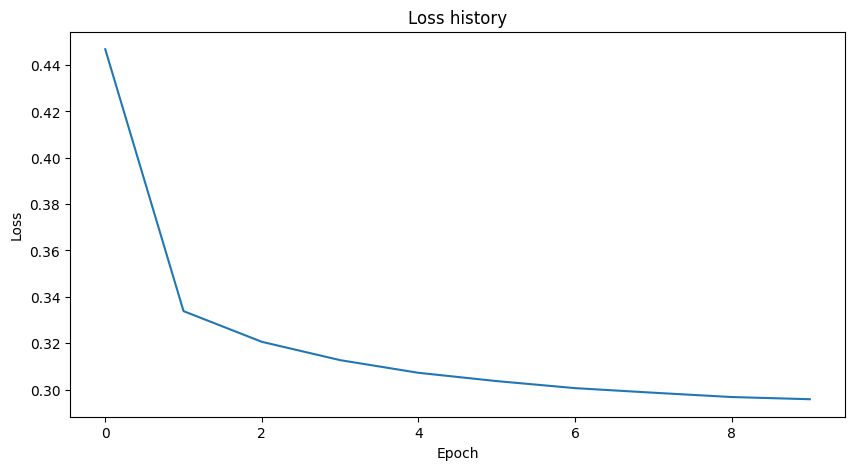

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(loss_hisory)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss history")
plt.show()

In [35]:
torch.save(w, "result/w.pth")
torch.save(c, "result/c.pth")


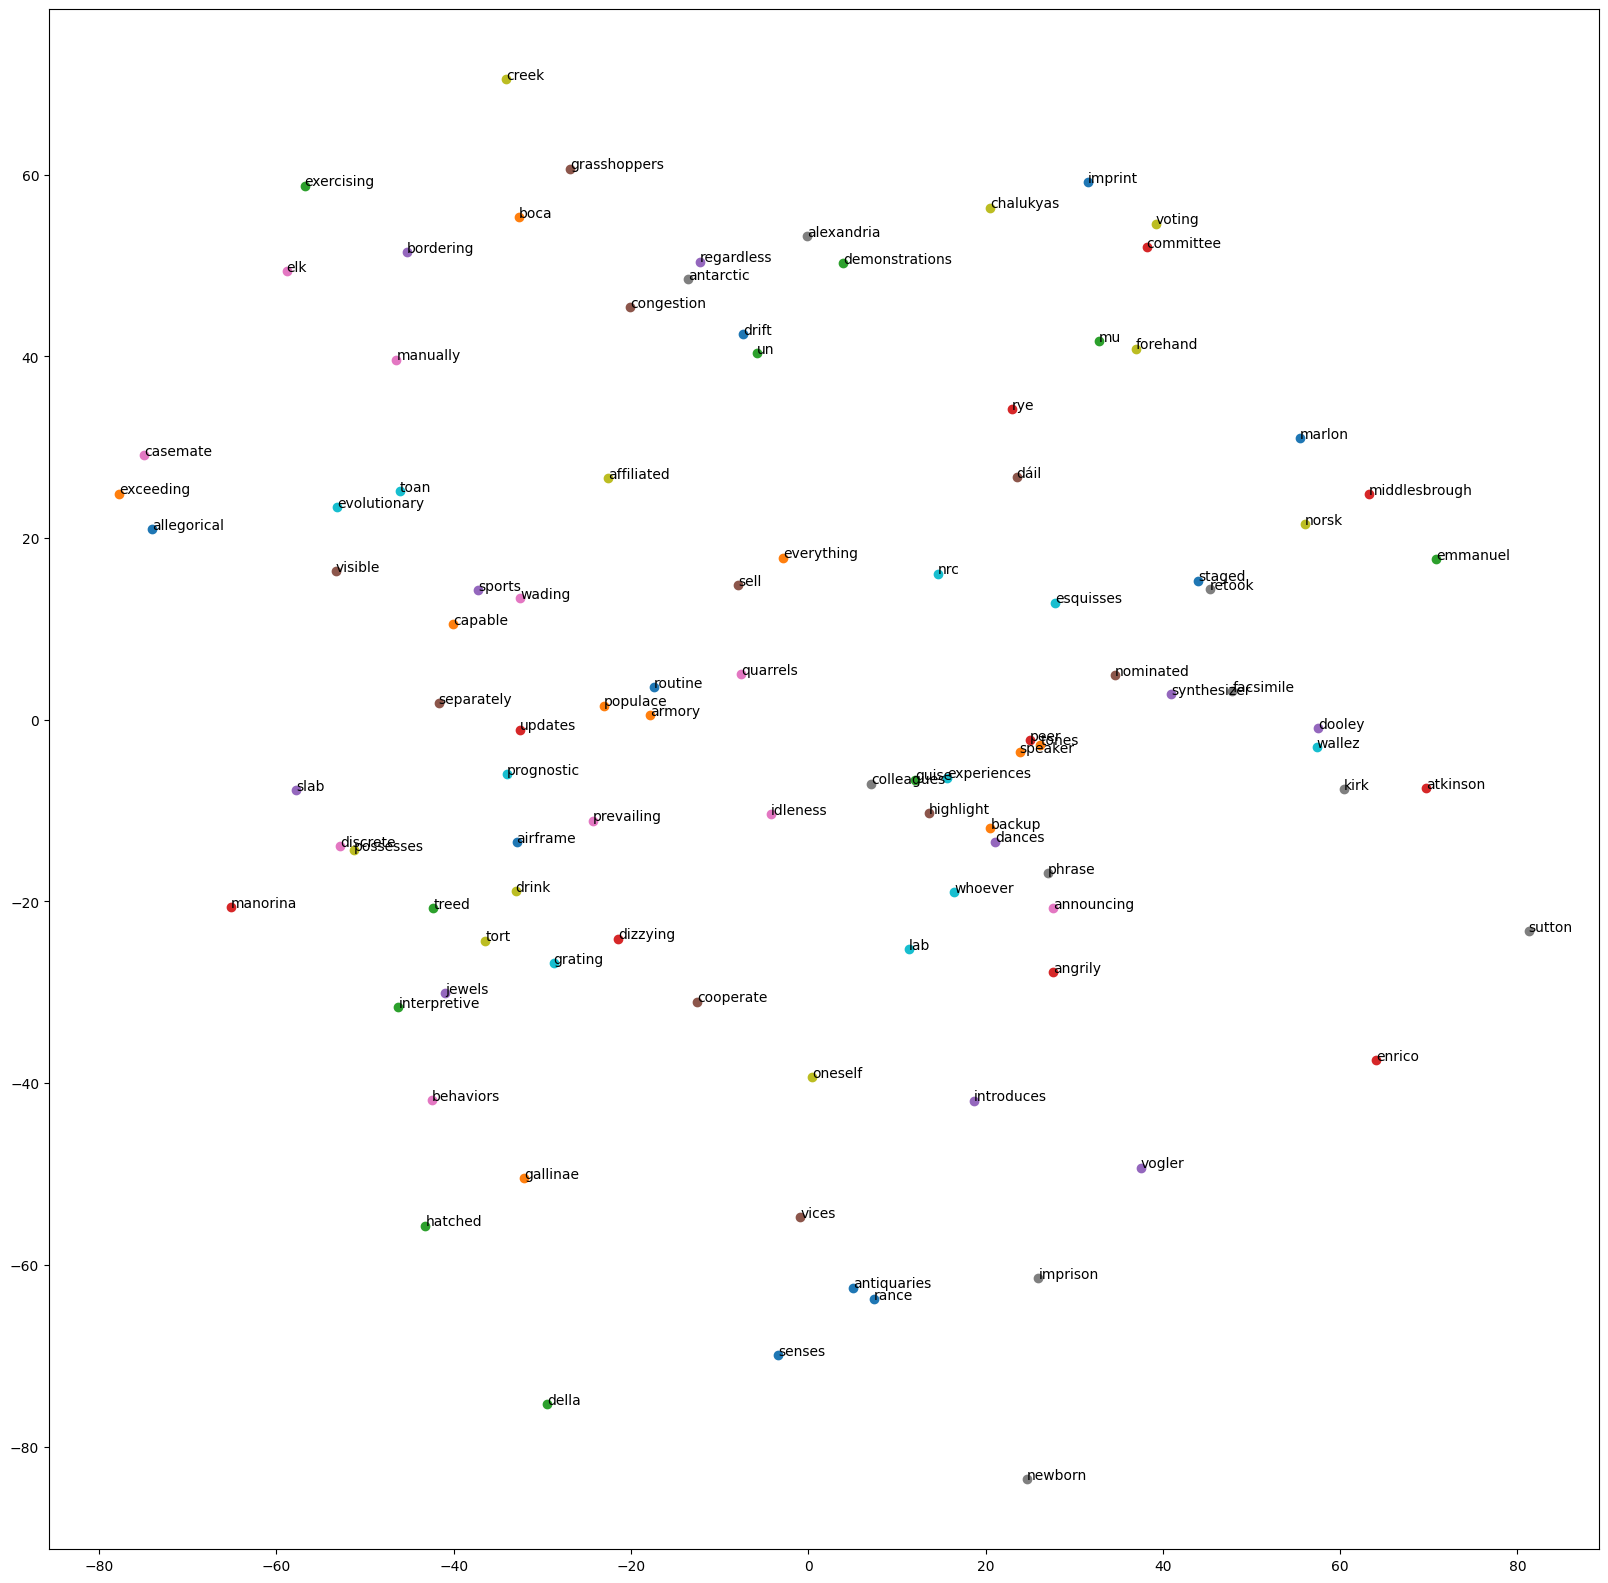

In [38]:
# visualize the word vectors with t-SNE
from sklearn.manifold import TSNE
import numpy as np

vectors = w + c
vectors = vectors.cpu().detach().numpy()
tsne = TSNE(n_components=2)
vectors = tsne.fit_transform(vectors)

plt.figure(figsize=(20, 20))

sample_vocab = random.sample(vocab, 100)
for word in sample_vocab:
    idx = word_to_idx[word]
    plt.scatter(vectors[idx, 0], vectors[idx, 1])
    plt.annotate(word, (vectors[idx, 0], vectors[idx, 1]))
plt.show()
